In [1]:
import os
import pickle
from collections import Counter
import torch, torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence
import time
import nltk

In [ ]:
DATA_PATH = ''
%matplotlib inline

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

In [ ]:
%%bash
mkdir '/content/data'
tar -xvf '/content/gdrive/My Drive/Colab Notebooks/handout.tar.gz' -C '/content/'

data/
data/captions_tokenized.json
data/image_codes.npy


mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [ ]:
# посмотрим на датасет

print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [ ]:
class Vocabulary(object):
  def __init__(self,
               vocab_threshold,
               vocab_file = '/content/data/vocab.pkl',
               start_word='<bos>',
               end_word='<eos>',
               pad_word='<pad>',
               unk_word='<unk>',
               path_tokenized_file = '/content/data/captions_tokenized.json',
               vocab_from_file = False):
      ''' Инициализация парамметров словаря.
          Параметры:
          vocab_threshold: Минимальное количество слов для добавления в словарь
                           слова.
          vocab_file: Файл со словарем.
          start_word: Специальный символ для указания начала в предложении.
          end_word: Специальный символ для указания конца в предложении.
          pad_word: Специальный символ для указания пропуска в предложении.
          unk_word: Специальный символ для указания неизвестного слова 
                    в предложении.
          capt_tokenized_file: Путь до токенизированных данных.
          vocab_from_file: Если False, то создает словарь и записывает его 
                           в vocab_file. Если True, то подгружает его из 
                           vocab_file если он существует.
      '''
      self.vocab_threshold = vocab_threshold
      self.vocab_file = vocab_file
      self.start_word = start_word
      self.end_word = end_word
      self.pad_word = pad_word
      self.unk_word = unk_word
      self.path_tokenized_file = path_tokenized_file
      self.vocab_from_file = vocab_from_file
      self.get_vocab()
    
  def get_vocab(self):
      '''Загружает файл словаря или создает его и сохраняет'''
      if os.path.exists(self.vocab_file) & self.vocab_from_file:
          with open(self.vocab_file, "rb") as f:
              vocab = pickle.load(f)
              self.word2idx = vocab.word2idx
              self.idx2word = vocab.idx2word
              print("Vocabulary successfully loaded from vocab.pkl file!")
      else:
          self.build_vocab()
          with open(self.vocab_file, "wb") as f:
              pickle.dump(self, f)

  def build_vocab(self):
      '''Создание словаря и наполнение его словами'''
      self.init_vocab()
      self.add_word(self.unk_word)
      self.add_word(self.start_word)
      self.add_word(self.end_word)
      self.add_word(self.pad_word)
      self.add_captions()

  def init_vocab(self):
      '''Инициализация словаря'''
      self.word2idx = {}
      self.idx2word = {}
      self.idx = 0

  def add_word(self, word):
      '''Добавление токена и количества в словарь'''
      if not word in self.word2idx:
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          self.idx += 1

  def add_captions(self):
      '''Цикл для добавления слов из всего текста в словарь с ограничением по 
         количеству слов'''
      captions = json.load(open(self.path_tokenized_file))
      counter = Counter()
      
      for img_i in range(len(captions)):
          for caption_i in range(len(captions[img_i])):
              sentence = captions[img_i][caption_i]
              counter.update(sentence.split(' '))

          if img_i % 50000 == 0:
              print("[%d/%d] Building vocab..." % (img_i, len(captions)))

      print('[%d/%d] Finish!' % (len(captions), len(captions)))
      
      words = [word for word, count in counter.items()
               if count >= self.vocab_threshold]

      for i, word in enumerate(words):
          self.add_word(word)

  def get_idx(self, word):
      if not word in self.word2idx:
          return self.word2idx[self.unk_word]
      return self.word2idx[word]

  def get_word(self, idx):
      if not idx in self.idx2word:
          return self.unk_word
      return self.idx2word[idx]

  def __len__(self):
      return len(self.word2idx)

vocab = Vocabulary(vocab_threshold = 5)

[0/118287] Building vocab...
[50000/118287] Building vocab...
[100000/118287] Building vocab...
[118287/118287] Finish!


In [ ]:
sample_caption = 'large piles of carrots and potatoes at a crowded outdoor market .'
sample_result = []

sample_result.append(imp.get_idx('<bos>'))
sample_result.extend([imp.get_idx(token) for token in sample_caption.split(' ')])
sample_result.append(imp.get_idx('<eos>'))

print(sample_caption)
print(sample_result)

large piles of carrots and potatoes at a crowded outdoor market .
[1, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26, 9, 12, 2]


In [ ]:
sample_caption = 'large piles of carrots and potatoes at a crowded outdoor market .'
sample_result = []

sample_result.append(vocab.get_idx('<bos>'))
sample_result.extend([vocab.get_idx(token) for token in sample_caption.split(' ')])
sample_result.append(vocab.get_idx('<eos>'))

print(sample_caption)
print(sample_result)

sample_caption = 'people shop for vegetables like carrots and potatoes at an open air market .'
sample_result = []

sample_result.append(vocab.get_idx('<bos>'))
sample_result.extend([vocab.get_idx(token) for token in sample_caption.split(' ')])
sample_result.append(vocab.get_idx('<eos>'))

print('')
print(sample_caption)
print(sample_result)

large piles of carrots and potatoes at a crowded outdoor market .
[1, 21, 16, 14, 22, 15, 23, 18, 24, 25, 26, 9, 12, 2]

people shop for vegetables like carrots and potatoes at an open air market .
[1, 4, 27, 10, 11, 28, 22, 15, 23, 18, 7, 8, 19, 9, 12, 2]


In [ ]:
class BatchIterator():
    def __init__(self, img_codes, captions, vocab, batch_size=32, shuffle=True, device=torch.device('cpu')):
        '''Инициализация иттератора батчей.
           img_codes: Данные с векторами картинок.
           captions: Данные с описаниями картинок.
           vocab: Словарь слов и их коды
           batch_size: Размер батча на выходе
           shuffle: Флаг для перемешивания выборки
           device: Использование cpu/gpu
        '''
        self.img_codes = img_codes
        self.img_size = img_codes.shape[1]
        self.captions = captions
        self.num_samples = len(captions)
        self.vocab = vocab
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device

    def __len__(self):
        return self.batches_count

    def max_length_caption(self, batch):
        '''Подсчет максимальной длинны предложений в батче'''
        max_lenght = 0
        
        for caption in batch:
            if len(caption) > max_lenght:
              max_lenght = len(caption)
        
        return max_lenght

    def __iter__(self):
        '''Функция позволяющая иттерироваться по батчам'''
        indices = np.arange(self.num_samples) # TODO: Учетом нескольких описаний к одной картинке

        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_image = []
            batch_caption = []

            for img_idx in batch_indices:
                # Берем описания для img_idx-картинки
                image_captions = self.captions[img_idx] 
                # Генерируем случайно число для выбора одного описания 
                capt_ind = np.random.randint(0, len(image_captions))
                
                # Добавляем к предложению спец. симв. и токенизируем его
                caption = []
                caption.append(self.vocab.get_idx(self.vocab.start_word))
                caption.extend([self.vocab.get_idx(token) for token in image_captions[capt_ind].split(' ')])
                caption.append(self.vocab.get_idx(self.vocab.end_word))

                # Наполняем батчи
                batch_image.append(self.img_codes[img_idx])
                batch_caption.append(caption)

            # Ищем максимальную длину предложения в батче
            # и дополняем остальные <pad>-ми до этого размера 
            max_length = self.max_length_caption(batch_caption)
            for i, caption in enumerate(batch_caption):
                batch_caption[i] = caption + [self.vocab.get_idx(self.vocab.pad_word)] * (max_length - len(caption))

            # Оборачиваем в тензоры
            tensor_image = torch.zeros((self.batch_size, self.img_size), dtype=torch.float32, device=self.device) 
            tensor_caption = torch.zeros((self.batch_size, max_length), dtype=torch.int64, device=self.device)

            for i, iamges in enumerate(batch_image):
                tensor_image[i][:len(iamges)] = torch.FloatTensor(iamges)
            
            for i, captions in enumerate(batch_caption):
                tensor_caption[i][:len(captions)] = torch.IntTensor(captions)

            yield {
                'images': tensor_image,
                'captions': tensor_caption,
            }

In [ ]:
#Пример работы батч - итератора 
train_iterator = BatchIterator(img_codes, captions, vocab, 4)

for batch in train_iterator:
    print('Image vector:', batch['images'].shape)
    print(batch['images'][:, :-1], '\n')
    print(batch['images'][:, :], '\n')
    print('Caption vector:', batch['captions'].shape)
    print(batch['captions'][:, :], '\n')
    print(batch['captions'][:, :-1], '\n')
    print('Caption text:', [vocab.get_word(idx.item()) for idx in batch['captions'][0]])
    break

Image vector: torch.Size([4, 2048])
tensor([[0.1093, 0.9802, 0.3289,  ..., 0.0626, 0.0157, 0.5124],
        [0.0482, 0.2900, 1.3037,  ..., 0.3460, 0.1231, 0.8716],
        [0.3246, 0.1274, 0.1838,  ..., 0.0000, 0.0000, 0.5943],
        [0.0805, 0.2524, 0.0591,  ..., 0.0662, 0.4299, 0.4530]]) 

tensor([[0.1093, 0.9802, 0.3289,  ..., 0.0157, 0.5124, 0.0360],
        [0.0482, 0.2900, 1.3037,  ..., 0.1231, 0.8716, 0.0924],
        [0.3246, 0.1274, 0.1838,  ..., 0.0000, 0.5943, 0.3551],
        [0.0805, 0.2524, 0.0591,  ..., 0.4299, 0.4530, 0.0487]]) 

Caption vector: torch.Size([4, 15])
tensor([[   1,   24,  304,   58,   24,  133,   14,   24,  203,   50,   59,  304,
           12,    2,    3],
        [   1,   24,  155,  154,   58,   24,  962,   15,   24, 1570,   12,    2,
            3,    3,    3],
        [   1,   24, 2304,   35,   45,  331,   14,   45,  103, 2302, 1371,   12,
            2,    3,    3],
        [   1,   24,   21,  404,    0,  718,  889,  183,   45,  331,   14,   24,
  

In [ ]:
#Разбиваем выборку на train, test, valid (60/30/10) и добавляем для них иттериуемые переменные.

def train_test_split(images, captions, train_size=0.9, valid_size=0.1, shuffle=True):
    train_shape = int(np.floor(images.shape[0] * train_size))
    valid_shape = int(np.floor(images.shape[0] * valid_size))

    if images.shape[0] != sum([train_shape, valid_shape]):
        last = images.shape[0] - sum([train_shape, valid_shape])
        train_shape += last

    print('All data shape', images.shape[0])
    print('-------------------------------')
    print('Train shape -', train_shape)
    print('Valid shape -', valid_shape)

    train_indices = np.arange(train_shape)
    valid_indices = np.arange(valid_shape)

    if shuffle:
        np.random.shuffle(train_indices) 
        np.random.shuffle(valid_indices)

    images_train = np.array(images)[train_indices]
    captions_train = np.array(captions)[train_indices]

    images_val = np.array(images)[valid_indices]
    captions_val = np.array(captions)[valid_indices]

    return images_train, captions_train, images_val, captions_val, train_shape, valid_shape

img_train, capt_train, img_val, capt_val, train_size, valid_size = train_test_split(img_codes, captions)

All data shape 118287
-------------------------------
Train shape - 106459
Valid shape - 11828


In [ ]:
print(img_train[0])
print(capt_train[0])

[0.13668247 0.40989295 0.18436697 ... 0.2333352  0.6180824  0.28760207]
['a large group of giraffes walk throught he zoo'
 'four giraffes standing around in a zoo pen .'
 'a couple of giraffes are standing in a pin'
 'giraffes walking in their enclosure on a sunny day .'
 'giraffes walk towards the back of a pen']


In [ ]:
print(img_val[0])
print(capt_val[0])

[0.5226549  0.07928751 0.8143755  ... 0.         0.9434766  0.43864805]
['a living room and kitchen with various furniture .'
 'the woman is working in the kitchen with the baby in the high chair next to her .'
 'a view of living room with brown sofas , with the kitchen in the background .'
 'a living room with a couch a chair and a tv'
 'a woman works in a kitchen that is joined to a living room .']


In [ ]:
class CaptionDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, cnn_feature_size = 2048, num_layers = 2):
        super(self.__class__, self).__init__()
        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        self.num_layers = num_layers

        self.img_to_h0 = nn.Linear(cnn_feature_size, hidden_size)
        self.img_to_h0 = nn.Linear(cnn_feature_size, hidden_size)
        self.tanh = nn.Tanh()
        # self.dropout = nn.Dropout(p=0.2)

        self.emb = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        self.logits = nn.Linear(hidden_size, vocab_size)
        

    def forward(self, image_vectors, captions):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption.
               shape: [batch_size, cnn_feature_size]
        
        :param captions_idx: таргет описания картинок в виде матрицы
               shape: [batch_size, word_i]
        
        :returns: outputs: логиты для сгенерированного текста описания
                  shape: [batch_size, word_i, p_vocab_i]
        """
        # 1. инициализируем LSTM state
        # [batch_size, hidden_size]
        h0 = self.tanh(self.img_to_h0(image_vectors))
        c0 = self.tanh(self.img_to_h0(image_vectors))
        
        # make [num_layer, batch_size, hidden_size]
        h0 = h0.expand(self.num_layers, h0.size(0), h0.size(1)).contiguous()
        c0 = c0.expand(self.num_layers, c0.size(0), c0.size(1)).contiguous()

        # 2. применим слой эмбеддингов к captions
        # [batch_size, max_len, emb_size]
        captions_emb = self.emb(captions)
        
        # 3. скормим LSTM captions_emb и добавим скрытые веса картинки 
        # [batch_size, max_len, hidden_size]
        hiddens, _ = self.lstm(captions_emb, (h0, c0))

        # 4. посчитаем логиты из выхода LSTM
        # [batch_size, max_len, vocab_size]
        logits = self.logits(hiddens)

        return logits

In [ ]:
def train_model(model, train_iterator, valid_iterator, vocablurary,
                batch_size=32, n_batches_per_epoch=32, n_validation_batches=5,
                n_epochs=1, device='cpu'):
    
    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Trainable params: {}'.format(params_count))
    print('-----------------------------------------')
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_idx('<pad>')).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, eps = 1e-8)

    best_val_loss = 1000
    avg_train_loss = []
    avg_val_loss = []
    start_time = time.time()

    for epoch in range(n_epochs):
      # Training part
      train_loss = 0
      model.train(True)
      for i, batch in enumerate(train_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        optimizer.zero_grad()
        logits = model(images, captions_ix_inp)
        
        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      train_loss /= n_batches_per_epoch
      avg_train_loss.append(train_loss)

      # Validation part
      val_loss = 0
      bleu = []
      sample_per_batch = True
      model.train(False)
      for _, batch in enumerate(valid_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        logits = model(images, captions_ix_inp)
        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        val_loss += loss.item()

        # На каждой эпохе смотрим как модель генерирует описание для изображения
        # на валидационной части
        if sample_per_batch:
            sample_per_batch = False
            sample_image = batch['images'][0].unsqueeze(0).to(device)
            sample_caption = batch['captions'][0].unsqueeze(0).to(device)

            original_sentence = [vocab.get_word(idx.item()) for idx in sample_caption[0][1:]]

            original_sentence = original_sentence[: original_sentence.index('<eos>')]
            print('Original:', original_sentence)

            logits = model(sample_image, sample_caption)
            scores = F.softmax(logits.cpu(), -1).data.numpy()[0]
            scores = scores ** 5 / np.sum(scores ** 5)
            #scores = scores / np.sum(scores)
            generated_sentence = [vocab.get_word(score) for score in np.argmax(scores, -1)]

            generated_sentence = generated_sentence[: generated_sentence.index('<eos>')]
            print('Generated:', generated_sentence)

            bleu.append(nltk.translate.bleu_score.sentence_bleu(original_sentence, generated_sentence))
      
      val_loss /= n_validation_batches
      avg_val_loss.append(val_loss)

      # Сохранение лучшей модели по лоссу на валидации 
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_model_base.ckpt')
      
      print("\nEpoch = {}, Avg Train Loss = {:.4f}, Avg Val Loss = {:.4f}, BLEU = {:.4f}, Best Val Loss = {:.4f}, Time = {:.2f}s\n" \
            .format(epoch+1, np.mean(avg_train_loss), np.mean(avg_val_loss), bleu[-1], 
                    best_val_loss, time.time() - start_time))
      start_time = time.time()

In [ ]:
def train_model(model, train_iterator, valid_iterator, vocablurary,
                batch_size=32, n_batches_per_epoch=32, n_validation_batches=5,
                n_epochs=1, device='cpu'):
    
    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Trainable params: {}'.format(params_count))
    print('-----------------------------------------')
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_idx('<pad>')).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, eps = 1e-8)

    best_val_loss = 1000
    avg_train_loss = []
    avg_val_loss = []

    bleu = []
    bleu_average = []
    bleu_best = 0
    start_time = time.time()

    for epoch in range(n_epochs):
      # Training part
      train_loss = 0
      model.train(True)
      for i, batch in enumerate(train_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        optimizer.zero_grad()
        logits = model(images, captions_ix_inp)
        
        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

      train_loss /= n_batches_per_epoch
      avg_train_loss.append(train_loss)

      # Validation part
      val_loss = 0
      temp = []

      model.train(False)
      for _, batch in enumerate(valid_iterator):
        images = batch['images'].to(device)
        captions_ix_inp = batch['captions'][:, :-1].contiguous().to(device)
        captions_ix_next = batch['captions'][:, 1:].contiguous().to(device)

        logits = model(images, captions_ix_inp)
        loss = criterion(logits.view(-1, logits.shape[2]), captions_ix_next.view(-1))

        val_loss += loss.item()


        sample_image = batch['images'][0].unsqueeze(0).to(device)
        sample_caption = batch['captions'][0].unsqueeze(0).to(device)
        original_sentence = [vocab.get_word(idx.item()) for idx in sample_caption[0][1:]]

        logits = model(sample_image, sample_caption)
        scores = F.softmax(logits.cpu(), -1).data.numpy()[0]
        scores = scores ** 5 / np.sum(scores ** 5)
        generated_sentence = [vocab.get_word(score) for score in np.argmax(scores, -1)]

        if '<eos>' in generated_sentence:
          generated_sentence = generated_sentence[: generated_sentence.index('<eos>')]

        temp.append(nltk.translate.bleu_score.sentence_bleu(original_sentence, generated_sentence))
        bleu.append(nltk.translate.bleu_score.sentence_bleu(original_sentence, generated_sentence))

      bleu_average.append(np.array(temp).mean())

      val_loss /= n_validation_batches
      avg_val_loss.append(val_loss)

      # Сохранение лучшей модели по лоссу на валидации 
      '''if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_model_base.ckpt')'''
      if bleu_best < bleu_average[-1]:
          best_val_loss = val_loss
          bleu_best = bleu_average[-1]
          torch.save(model.state_dict(), 'best_model_base.ckpt')
      
      print("\nEpoch = {}, Avg Train Loss = {:.4f}, Avg Val Loss = {:.4f}, bleu_average = {:.4f}, Best Val Loss = {:.4f}, Time = {:.2f}s\n" \
            .format(epoch+1, np.mean(avg_train_loss), np.mean(avg_val_loss), bleu_average[-1], 
                    best_val_loss, time.time() - start_time))
      start_time = time.time()
    return bleu, bleu_average, avg_train_loss, avg_val_loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 25
batch_size = 50
n_batches_per_epoch = np.floor(train_size / batch_size)
batch_valid_size = 25
n_validation_batches = np.floor(valid_size / batch_valid_size)
lstm_num_layers = 4

train_iterator = BatchIterator(img_train, capt_train, vocab, batch_size)
valid_iterator = BatchIterator(img_val, capt_val, vocab, batch_size)

model = CaptionDecoderRNN(embed_size=300,
                          hidden_size=512,
                          vocab_size=len(vocab),
                          cnn_feature_size=img_codes.shape[1],
                          num_layers=lstm_num_layers)

bleu, bleu_average, avg_train_loss, avg_val_loss = train_model(model, train_iterator, valid_iterator, vocab, batch_size,
            n_batches_per_epoch, n_validation_batches, n_epochs, device)

Text(0, 0.5, 'loss')

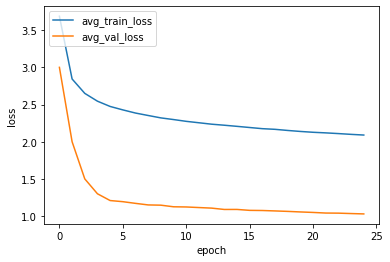

In [ ]:
import matplotlib.pyplot as plt
plt.plot(avg_train_loss, label = 'avg_train_loss')
plt.plot(test, label = 'avg_val_loss')
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'score')

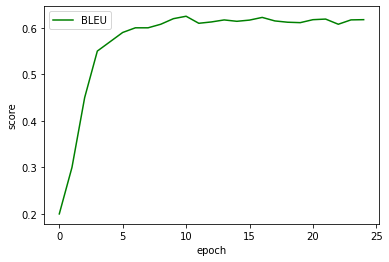

In [ ]:
plt.plot(bl, label = 'BLEU', color  ='g')
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('score')

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/master/homework04/beheaded_inception3.py

--2021-05-16 17:07:14--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/master/homework04/beheaded_inception3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1811 (1.8K) [text/plain]
Saving to: ‘beheaded_inception3.py’

beheaded_inception3 100%[===================>]   1.77K  --.-KB/s    in 0s      

2021-05-16 17:07:14 (22.8 MB/s) - ‘beheaded_inception3.py’ saved [1811/1811]



In [ ]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
def generate_caption(image, t=5, max_len=100, device='cpu'):
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

    vectors_8x8, vectors_neck, logits = inception(image[None])    
    captions_prefix = ['<bos>']

    for _ in range(max_len):
        # Получаем коды слов из словаря
        captions_ix = [vocab.get_idx(word) for word in captions_prefix]
        # Оборачиваем в торч тензор
        captions_ix = torch.tensor(captions_ix, dtype=torch.int64, device=device)

        # Получаем логиты следующего слова
        model = CaptionDecoderRNN(embed_size=300,
                          hidden_size=512,
                          vocab_size=len(vocab),
                          cnn_feature_size=img_codes.shape[1],
                          num_layers = 4)

        model.load_state_dict(torch.load('best_model_base.ckpt'))
        model.eval()

        next_word_logits = model.forward(vectors_neck.to(device), captions_ix.unsqueeze(0))[0, -1]
        # Преобразуем их в вероятности
        next_word_probs = F.softmax(next_word_logits.cpu(), -1).data.numpy()

        assert len(next_word_probs.shape) == 1
        
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)
        
        # Получаем слово в исходном виде
        next_word = vocab.get_word(np.argmax(next_word_probs).item())
        
        # Добавляем его к предложению
        captions_prefix.append(next_word)

        # Если сгенерировалось конец предложения, то останавливаем процесс
        if next_word == '<eos>':
            break
    
    return captions_prefix

In [ ]:
import os
import pickle
from collections import Counter
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import time

import numpy as np
device = torch.device('cpu')

--2021-05-05 16:51:12--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-05-05 16:51:13--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2021-05-05 16:51:13 (4.15 MB/s) - ‘img.jpg’ saved [54731

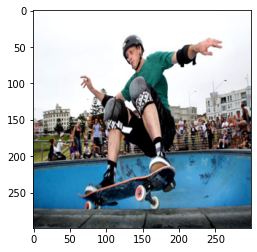

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299,299)))/255

plt.imshow(img)
for i in range(1):
    print(' '.join(generate_caption(img, t=5, device = device)[1:-1]))

In [ ]:
!pip install python-telegram-bot

     |████████████████████████████████| 460kB 4.3MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


In [ ]:
#Bot
from PIL import Image
from numpy import asarray 
import numpy as np
from numpy import asarray 

import logging
import telegram
from telegram import ReplyKeyboardMarkup, ReplyKeyboardRemove, Update
from telegram.ext import (
    Updater,
    CommandHandler,
    MessageHandler,
    Filters,
    ConversationHandler,
    CallbackContext,
)

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)

logger = logging.getLogger(__name__)
Token = '1316758016:AAHPElD6DNK4TmLLJvwGPgYzhWfEu-noEpg'
PHOTO, BIO = range(2)

bot = telegram.Bot(token=Token) 

def start(update: Update, context: CallbackContext) -> int:


    update.message.reply_text(
        'ololo',
    )

    return PHOTO


def photo(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    photo_file = update.message.photo[-1].get_file()

    print ("file_id: " + str(update.message.photo[-1].file_id))
    photo_file.download('image.jpg')
    img = plt.imread('/content/image.jpg')
    img = np.array(Image.fromarray(img).resize((299,299)))/255

    result = ' '.join(generate_caption(img, t = 5, device = device)[1:-1])


    logger.info("Photo of %s: %s", user.first_name, 'user_photo.jpg')


    update.message.reply_text(
        str(result)
    )
    return ConversationHandler.END



def cancel(update: Update, context: CallbackContext) -> int:
    user = update.message.from_user
    logger.info("User %s canceled the conversation.", user.first_name)
    update.message.reply_text(
        'Bye!.', reply_markup=ReplyKeyboardRemove()
    )

    return ConversationHandler.END


def main() -> None:
    updater = Updater(Token, use_context=True)

    dispatcher = updater.dispatcher

    conv_handler = ConversationHandler(
        entry_points=[CommandHandler('start', start)],
        states={
            PHOTO: [MessageHandler(Filters.photo, photo)],
        },
        fallbacks=[CommandHandler('cancel', cancel)],
    )

    dispatcher.add_handler(conv_handler)

    updater.start_polling()

    updater.idle()

if __name__ == '__main__':
    main()

2021-05-05 17:47:36,810 - apscheduler.scheduler - INFO - Scheduler started


file_id: AgACAgIAAxkBAAICOWCS2ksEFh4K1I1uwdH3ULTd9QlWAAKYuTEbGCOYSL4duKvgdy2kZGkRpC4AAwEAAwIAA3kAA-O1AAIfBA


2021-05-05 17:48:01,062 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICPWCS2qe8YWRnIROKPwHVVhi_3BurAAKuuTEbGCOYSAR1F_E3jq5yCL6Hoi4AAwEAAwIAA3kAA5rcAQABHwQ


2021-05-05 17:49:31,822 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICQWCS2tpOG2vAMD53sDlMl8OOy4w2AAKvuTEbGCOYSDEgJyfL-TGsYjsJni4AAwEAAwIAA3kAA6CqAwABHwQ


2021-05-05 17:50:23,016 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICRWCS2xPdVSZ1onVYbk5T-gRJeOeRAAKyuTEbGCOYSNUPbr56CA0DViUfpC4AAwEAAwIAA3kAA5CxAAIfBA


2021-05-05 17:51:20,216 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICSWCS271U3HfGkszeQQPPZ3S3_9DqAAKzuTEbGCOYSNJbXjw1WNCj7YeHnS4AAwEAAwIAA3kAA_HoAQABHwQ


2021-05-05 17:54:09,950 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICTmCS3AQqndw2Vf2meptrcpC6Q18mAAK_uTEbGCOYSDNGZZfzBOqHOgSPoS4AAwEAAwIAA3kAA0DlAQABHwQ


2021-05-05 17:55:20,707 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICUmCS436w4NN07wkQXY-1OdOYllDcAALluTEbGCOYSP1CCkR5OedBaVulmy4AAwEAAwIAA3kAA5mBAAIfBA


2021-05-05 18:27:15,429 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICV2CS5AM-HVDYwfg0HXJKa1uNIYcnAALouTEbGCOYSLSIWQ6rhORt76oNoi4AAwEAAwIAA3kAA5zdAQABHwQ


2021-05-05 18:29:27,881 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICXGCS5ET9UjI-omVhBC7qcHbptuXXAALpuTEbGCOYSH1dXjyvv-pDRZ-eoi4AAwEAAwIAA3kAAzLFAQABHwQ


2021-05-05 18:30:33,162 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICYGCS5JrxG4VHOKByw6UGOJv5unw7AALquTEbGCOYSEKtHLuykbrHDa8DpC4AAwEAAwIAA3kAAy2vAAIfBA


2021-05-05 18:31:59,198 - __main__ - INFO - Photo of Semyon: user_photo.jpg


file_id: AgACAgIAAxkBAAICZGCS5N8fwyU1VggM9jrUOHLjwQWrAALruTEbGCOYSEZHtFwtAprJSXWAoy4AAwEAAwIAA3kAA654AAIfBA


2021-05-05 18:33:08,589 - __main__ - INFO - Photo of Semyon: user_photo.jpg
2021-05-05 19:06:04,422 - telegram.ext.updater - INFO - Received signal 2 (SIGINT), stopping...
2021-05-05 19:06:04,428 - apscheduler.scheduler - INFO - Scheduler has been shut down
